## Testing Watershed Segmentation - PlantCV

In [1]:
%matplotlib inline

import json

import cv2
import skimage

import numpy as np

from PIL import Image
from skimage.feature import peak_local_max
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from plantcv import plantcv as pcv

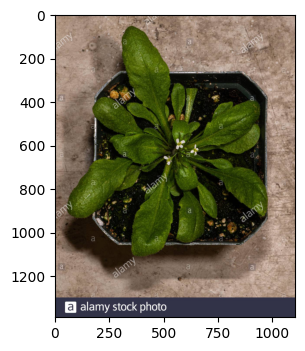

In [2]:
class options:
    def __init__(self):
        self.image = "./img/arabidopsis.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Read image

# Inputs:
#  filename = Image file to be read in
#  mode - Return mode of image; either 'native' 
#         (default), 'rgb', 'gray', or 'csv'

img, path, filename = pcv.readimage(filename=args.image)

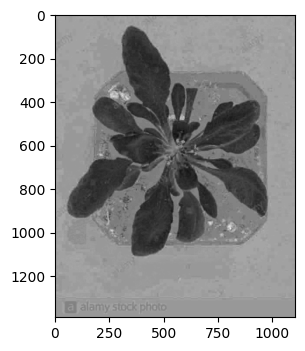

In [3]:
# Convert image from RGB color space to LAB and keep only the 
# green-magenta channel 

# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)

a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

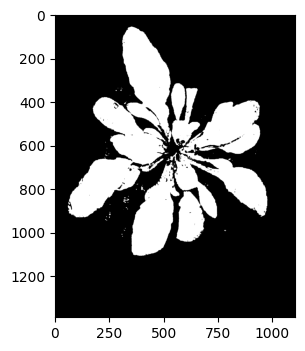

In [4]:
# Set a binary threshold on the image 

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done

img_binary = pcv.threshold.binary(gray_img=a, threshold=116, max_value=255, object_type='dark')

In [5]:
# Median Blur to clean noise 

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
####img_binary = pcv.median_blur(gray_img=img_binary, ksize=20)
#img_binary = pcv.gaussian_blur(img=img_binary, ksize=(5, 5), sigma_x=6, sigma_y=None)
# Note: The gaussian blue left too much noise

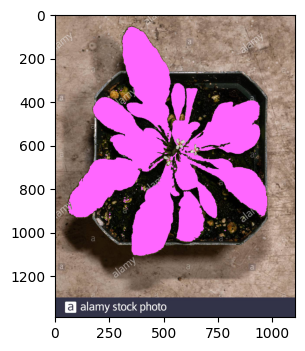

In [6]:
# Find objects

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection

id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=img_binary)

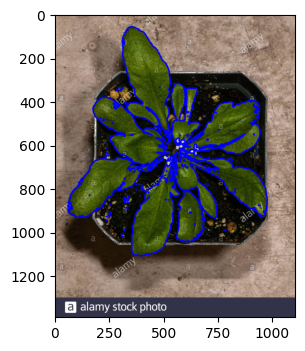

In [7]:
# Combine objects 

# Inputs:
#   img       = RGB or grayscale image data for plotting 
#   contours  = Contour list 
#   hierarchy = Contour hierarchy array 

obj, mask = pcv.object_composition(img=img, contours=id_objects, hierarchy=obj_hierarchy)

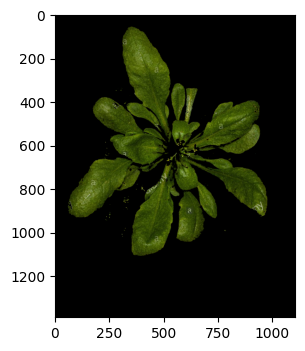

In [8]:
# Appy mask

# Inputs:
#   img        = RGB or grayscale image data 
#   mask       = Binary mask image data 
#   mask_color = 'white' or 'black' 

masked = pcv.apply_mask(img=img, mask=mask, mask_color="black")

/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


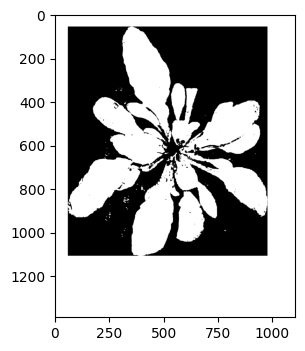

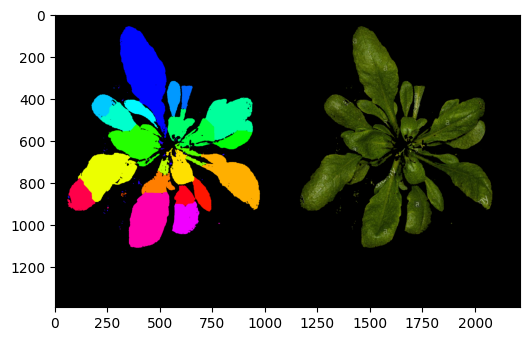

In [9]:
# Use watershed segmentation 

# Inputs:
#   rgb_img  = RGB image data 
#   mask     = Binary image, single channel, object in white and background black
#   distance = Minimum distance of local maximum, lower values are more sensitive, 
#              and segments more objects (default: 10)
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)


analysis_images = pcv.watershed_segmentation(rgb_img=masked, mask=mask, distance=35, label="default")

In [10]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename='segmentation_results.json')

In [11]:
res = {}
with open('segmentation_results.json', 'r') as results:
    res = json.loads(results.read())
    print(json.dumps(res, indent=2))

{
  "metadata": {},
  "observations": {
    "default": {
      "estimated_object_count": {
        "trait": "estimated object count",
        "method": "plantcv.plantcv.watershed",
        "scale": "none",
        "datatype": "<class 'int'>",
        "value": 28,
        "label": "none"
      }
    }
  }
}


In [12]:
print(f"Number of leaves: {res['observations']['default']['estimated_object_count']['value']}")

Number of leaves: 28


In [13]:
# Marker-based Watershed segmentation with the K means algorithm
# http://datahacker.rs/007-opencv-projects-image-segmentation-with-watershed-algorithm/



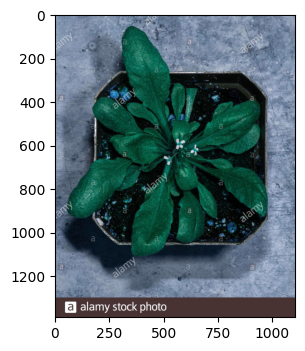

In [14]:
img_cv = cv2.imread('./img/arabidopsis.jpg')
#img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_cv)
plt.show()

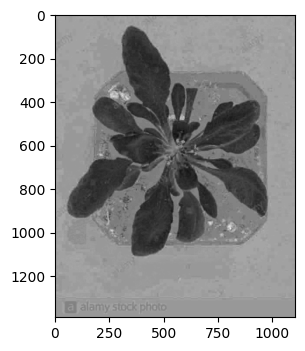

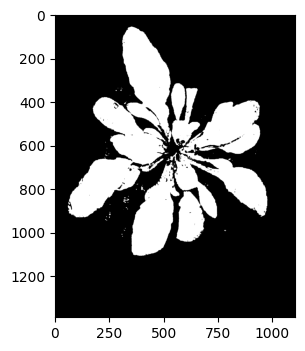

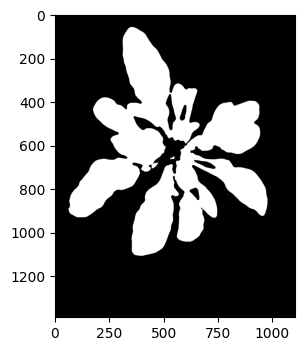

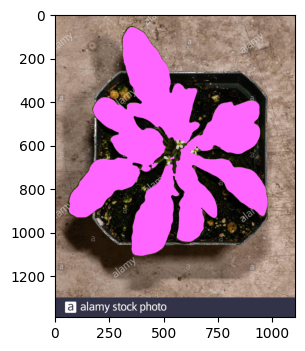

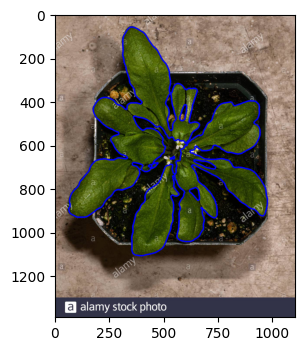

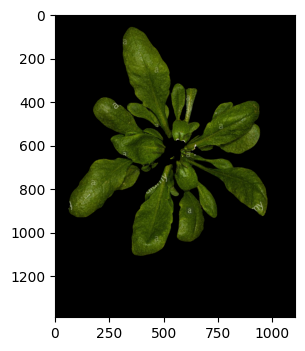

In [15]:
a = pcv.rgb2gray_lab(rgb_img=img_cv, channel='a')
img_binary = pcv.threshold.binary(gray_img=a, threshold=116, max_value=255, object_type='dark')
img_binary = pcv.median_blur(gray_img=img_binary, ksize=20)
id_objects, obj_hierarchy = pcv.find_objects(img=img_cv, mask=img_binary)
obj, mask = pcv.object_composition(img=img_cv, contours=id_objects, hierarchy=obj_hierarchy)
masked = pcv.apply_mask(img=img_cv, mask=mask, mask_color="black")

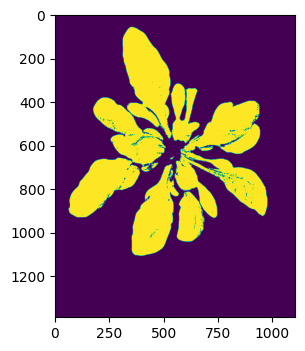

In [16]:
gray = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)
ret, thresh_img = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_img)
plt.show()

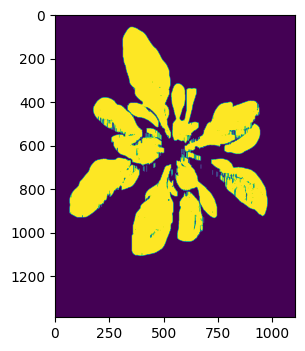

In [17]:
# Noise removal
kernel = np.ones((3), np.uint8)
opening_img = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=9)

plt.imshow(opening_img)
plt.show()

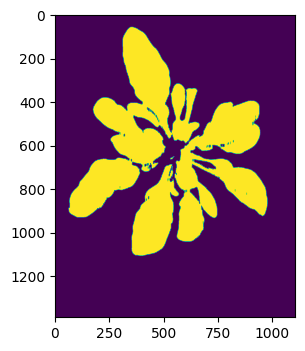

In [18]:
# Noise removal
closing_img = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernel, iterations=4)

plt.imshow(closing_img)
plt.show()

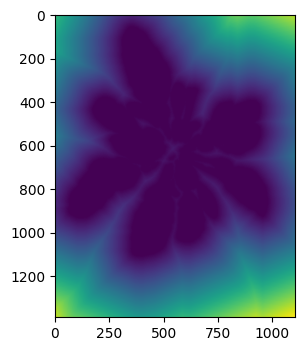

In [19]:
dist_transform = cv2.distanceTransform(255 - closing_img, cv2.DIST_L2, 3)
plt.imshow(dist_transform)
plt.show()

In [20]:
local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)

<ipython-input-20-0666ea1cf979>:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


In [21]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(local_max_location)
local_max_location = kmeans.cluster_centers_.copy()

In [22]:
# Kmeans is returning a float data type so we need to convert it to an int. 
local_max_location = local_max_location.astype(int)

In [23]:
local_max_location.shape
dist_transform_copy = dist_transform.copy()
for i in range(local_max_location.shape[0]):
    cv2.circle(dist_transform_copy, (local_max_location[i][1], local_max_location[i][0]), 5, 255)

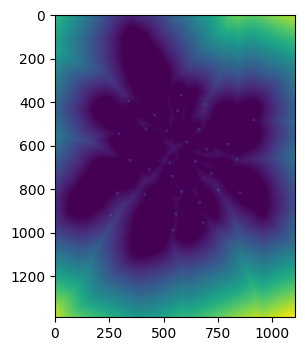

In [24]:
plt.imshow(dist_transform_copy)
plt.show()

In [25]:
#markers = np.zeros_like(dist_transform)
ret, sure = cv2.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
sure = np.uint8(sure)
ret, markers = cv2.connectedComponents(sure)
labels = np.arange(kmeans.n_clusters)
markers[local_max_location[:,0], local_max_location[:,1]] = labels + 1

In [26]:
# Convert all local markers to an integer. This because cluster centers will be float numbers. 
markers = markers.astype(int)

In [27]:
markers_copy = markers.copy()
index_non_zero_markers = np.argwhere(markers != 0)

In [28]:
markers_copy = markers_copy.astype(np.uint8)

In [29]:
index_non_zero_markers
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(index_non_zero_markers.shape[0]):
    string_text = str(markers[index_non_zero_markers[i][0], index_non_zero_markers[i][1]])
    cv2.putText(markers_copy, string_text, (index_non_zero_markers[i][1], index_non_zero_markers[i][0]), font, 1, 255)

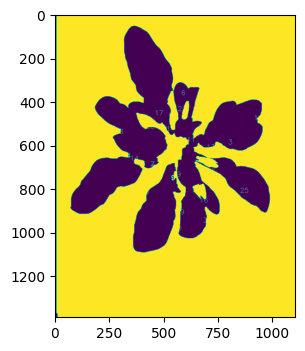

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

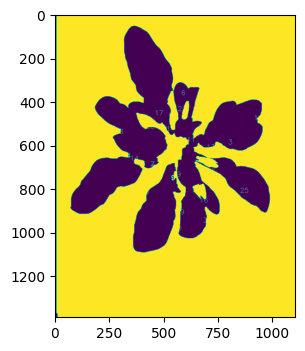

In [30]:
plt.imshow(markers_copy)
plt.show(markers_copy)

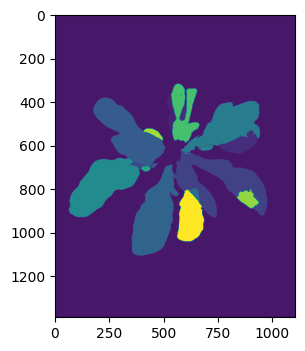

In [31]:
markers = markers.astype(np.int32)
segmented = cv2.watershed(masked, markers)
plt.imshow(segmented)
plt.show()

In [37]:
markers[0]

array([-1, -1, -1, ..., -1, -1, -1], dtype=int32)

In [55]:
from collections import Counter
from itertools import takewhile
cnt = Counter()
for row in markers:
    cnt.update(row)
n_cnt = dict(takewhile(lambda x: x[1] >= 10, cnt.most_common()))
del n_cnt[1]
del n_cnt[-1]

In [57]:
len(n_cnt.keys())

20

In [34]:
segmented.shape

(1390, 1107)

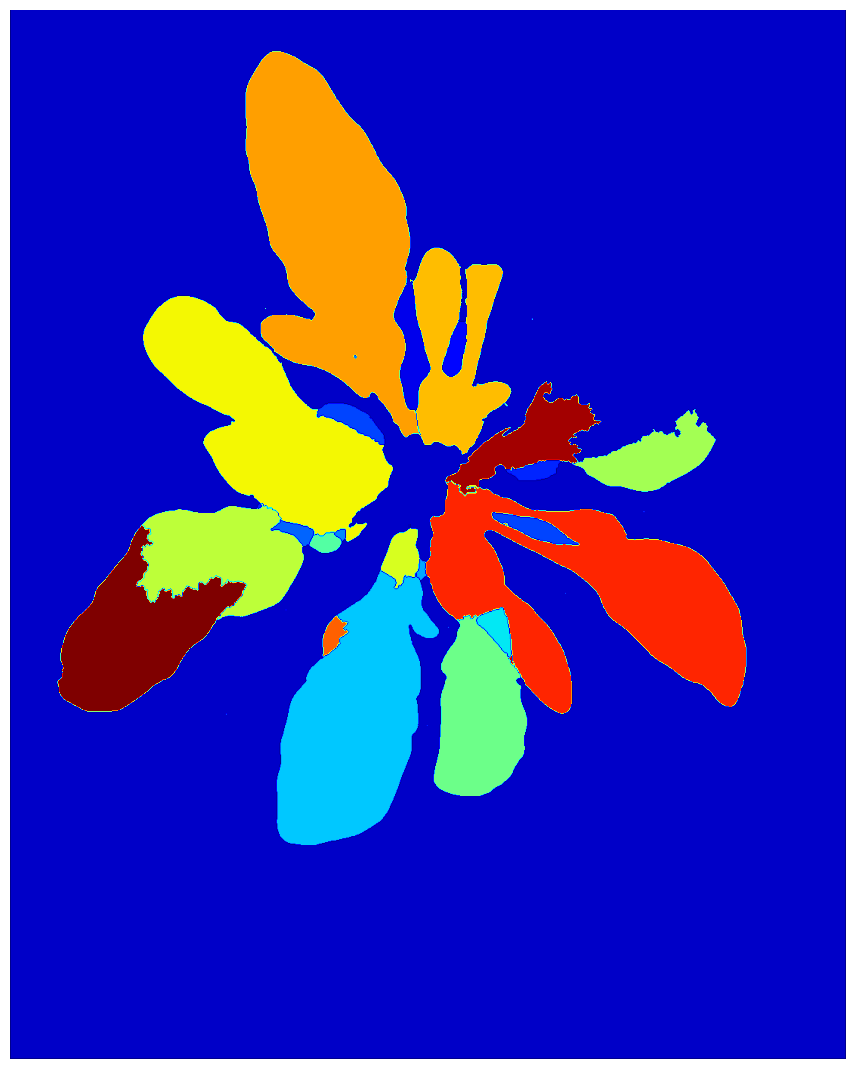

In [312]:
dpi = plt.rcParams['figure.dpi']
figsize = masked.shape[1] / float(dpi), masked.shape[0] / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(segmented, cmap="jet")
filename = "markers.jpg"
plt.axis('off')
plt.savefig(filename, bbox_inches='tight', pad_inches=0)

In [313]:
overlay = cv2.imread("markers.jpg")
overlay = np.asarray(overlay)

In [314]:
img_copy = masked.copy()
overlay_copy = overlay.copy()

In [315]:
overlay_copy = cv2.resize(overlay_copy, (img_copy.shape[1], img_copy.shape[0]))
final_img = cv2.addWeighted(overlay_copy, 0.5, img_copy, 0.5, 0)

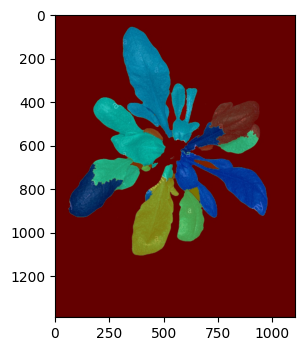

In [316]:
plt.imshow(final_img)
plt.show()

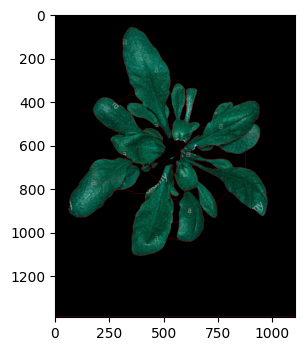

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

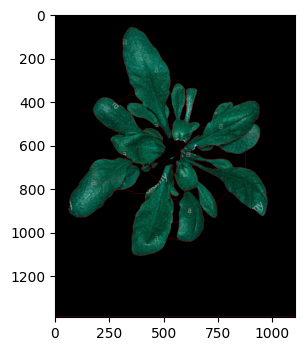

In [242]:
img_c = masked.copy() 
img_c[segmented == -1] = [255, 0, 0]
plt.imshow(img_c)
plt.show(img_c)